In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

from ann_utils import *

Using TensorFlow backend.


In [2]:
preproc_folder = "enriched_time"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
output_path = "../data/models/"

prefix = 'time_2018-02-20_p180_bg_'
postfix = '_190721_170'
trainfile = '_traindata'
testfile = '_testdata'

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix+trainfile+postfix+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix+testfile+postfix+'.pkl') 

In [3]:
len(feature_labels)

35

In [4]:
#settings for mlp architecture
#input_shape = len(feature_labels)
#hidden_layers_no=2 
#hidden_nodes=[20,5] 
#hl_activations=[tf.nn.relu]*2 
#optimizer=Adam()
#loss_func='binary_crossentropy'
#metrics=['accuracy',tf.keras.metrics.AUC(),
#                                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
#dropout = [0.5]*2

#mlp = create_mlp_model(input_shape=input_shape, 
#                       hidden_layers=hidden_layers,
#                       hidden_nodes=hidden_nodes, 
#                       hl_activations=hl_activations,                                        
#                       optimizer = optimizer,
#                       loss_func=loss_func,
#                      #kernel_regularizers = [l2(0.001)]*3,
#                       dropout = dropout,
#                      metrics = metrics)

#settings for fitting the model
#to_monitor = 'auc'+mlp.name.split('sequential')[-1]
#DISABLED early_stopping = TerminateOnBaseline(monitor=to_monitor #keep track of the model name adding the postfix to the metric to monitor
#                                     , baseline=0.93)
#batch_size = 256
#epochs=150
#class_1_weight = 10

#creating validation data
#validation_size = 20000

#Shuffle set to true

In [5]:
#settings for mlp architecture
input_shape = len(feature_labels)
hidden_layers_no=5 
hidden_nodes=[80,60,40,20,10] 
hl_activations=[tf.nn.relu]*5 
optimizer=Adam()
loss_func='binary_crossentropy'
metrics=['accuracy',tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
dropout = [0.6]*5

mlp = create_mlp_model(input_shape=input_shape, 
                       hidden_layers_no=hidden_layers_no,
                       hidden_nodes=hidden_nodes, 
                       hl_activations=hl_activations,                                        
                       optimizer = optimizer,
                       loss_func=loss_func,
                      #kernel_regularizers = [l2(0.001)]*3,
                       dropout = dropout,
                      metrics = metrics)

#settings for fitting the model
to_monitor = 'accuracy' #+mlp.name.split('sequential')[-1]
early_stopping = TerminateOnBaseline(monitor=to_monitor #keep track of the model name adding the postfix to the metric to monitor
                                     , baseline=0.88)
batch_size = 256
epochs=150
class_1_weight = 10

#creating validation data
validation_size = 5000

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                2880      
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                8

In [6]:
X_train.shape

(42079, 35)

In [7]:
#fitting
X_val = X_train[:validation_size]
partial_X_train = X_train[validation_size:]
y_val = y_train[:validation_size]
partial_y_train = y_train[validation_size:]

history = mlp.fit(partial_X_train, partial_y_train, epochs=epochs,  batch_size = batch_size, verbose=1, 
        steps_per_epoch=math.ceil(X_train.shape[0]/batch_size), callbacks=[early_stopping],
                 validation_data=(X_val, y_val), class_weight={0:1, 1:class_1_weight}, 
                  shuffle=False)
        

Epoch 1/150
165/165 [==============================] - 24s 147ms/step - loss: 1.3150 - accuracy: 0.3082 - auc: 0.5242 - precision_1: 0.0954 - recall_1: 0.7679 - val_loss: 0.7110 - val_accuracy: 0.0516 - val_auc: 0.5032 - val_precision_1: 0.0267 - val_recall_1: 0.9924
Epoch 2/150
165/165 [==============================] - 24s 144ms/step - loss: 1.0968 - accuracy: 0.5535 - auc: 0.7545 - precision_1: 0.1515 - recall_1: 0.8361 - val_loss: 0.2173 - val_accuracy: 0.9384 - val_auc: 0.4872 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/150
165/165 [==============================] - 25s 149ms/step - loss: 0.8127 - accuracy: 0.7703 - auc: 0.8890 - precision_1: 0.2724 - recall_1: 0.8935 - val_loss: 0.4599 - val_accuracy: 0.9732 - val_auc: 0.4587 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/150
165/165 [==============================] - 24s 145ms/step - loss: 0.6820 - accuracy: 0.8196 - auc: 0.9207 - precision_1: 0.3272 - recall_1: 0.9075 - val_loss: 0.6259 - 

KeyboardInterrupt: 

In [61]:
history_dict = history.history

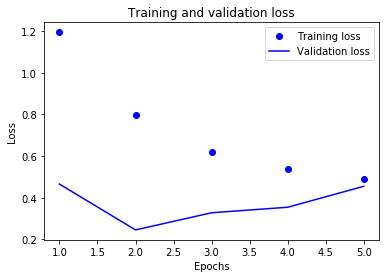

In [62]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

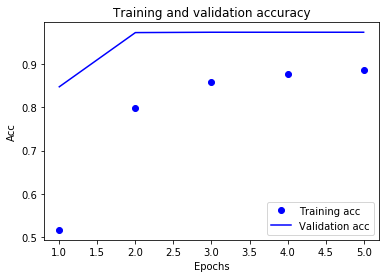

In [63]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()

plt.show()

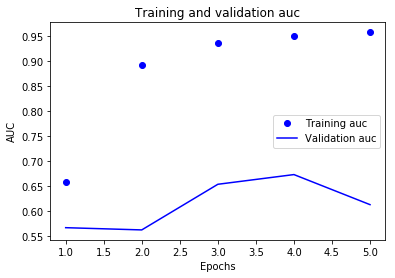

In [65]:
aucname = 'auc_4'

auc_values = history_dict[aucname]
val_auc_values = history_dict['val_'+aucname]
epochs = range(1, len(auc_values)+1)

plt.plot(epochs, auc_values, 'bo', label='Training auc')
plt.plot(epochs, val_auc_values, 'b', label='Validation auc')
plt.title("Training and validation auc")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.show()

In [66]:
predictions = mlp.predict(X_test)

In [67]:
y_test.shape

(15540,)

In [68]:
y_test.sum()

54

In [69]:
predictions.round().sum()

1481.0

In [70]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
fpr, tpr, thresholds = roc_curve(y_test, predictions) #false positive rate, true positive rate and thresholds
auc = roc_auc_score(y_test, predictions)
        
print('AUC: {}'.format(auc))

AUC: 0.8553388723865283


In [71]:
cm = confusion_matrix(y_test, predictions.round())
cm

array([[14033,  1453],
       [   26,    28]], dtype=int64)

In [72]:
from models_utils import cm_ratio
cm_ratio(cm)

Confusion matrix: 
[[0.90617 0.09383]
 [0.00168 0.00181]]


array([[0.90617332, 0.09382668],
       [0.00167894, 0.00180808]])

In [34]:
results_folder = '../data/viz_data/enriched_time_opt_p180_bg_/'
filename = 'time_2018-02-20_p180_bg__RandomForestClassifier_190721_239_viz.pkl'

res = pd.read_pickle(results_folder+filename)
res['RandomForestClassifier_time_2018-02-20_p180_bg_testing']

{'fpr': array([0.        , 0.00445564, 0.00452021, ..., 0.9997417 , 0.99987085,
        1.        ]),
 'tpr': array([0., 0., 0., ..., 1., 1., 1.]),
 'auc': 0.7886131320523675,
 'rcm': array([[0.8366912 , 0.1633088 ],
        [0.00200181, 0.00148521]])}